# `multidms` fitting pipeline

Here, we demonstrate the pipeline for fitting a `multidms` model on some data using the tools available in the package. Currently, we show how to pre-process data from various dms experiments targeting Delta and Omicron spike protein homologs.

In [2]:
# built-in libraries
import os
import sys
from itertools import combinations
from collections import defaultdict
import time

# external dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as onp
from tqdm.notebook import tqdm
import jax.numpy as jnp

import multidms
%load_ext autoreload
%autoreload 2
%matplotlib inline

**Read in the dms data and list all available experimental conditions**

In [3]:
func_score_data = pd.DataFrame()
sites = {}
wt_seqs = {}

for homolog in ["Delta", "Omicron_BA.1", "Omicron_BA.2"]:
    
    # functional scores
    func_sel = pd.read_csv(f"../results/{homolog}/functional_selections.csv")
    func_sel = func_sel.assign(
        filename = f"../results/{homolog}/" + 
        func_sel.library + "_" + 
        func_sel.preselection_sample + 
        "_vs_" + func_sel.postselection_sample + 
        "_func_scores.csv"
    )
    func_sel = func_sel.assign(
        func_sel_scores_df = func_sel.filename.apply(lambda f: pd.read_csv(f))
    )
    func_sel = func_sel.assign(
        len_func_sel_scores_df = func_sel.func_sel_scores_df.apply(lambda x: len(x))
    )
    fun_sel = func_sel.assign(homolog = homolog)
    func_score_data = pd.concat([func_score_data, fun_sel]).reset_index(drop=True)

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['condition'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}".replace('-Lib',''),
#     lambda row: f"{row['homolog']}-{row['library']}-{row['replicate']}".replace('-Lib',''),
    axis=1
)
func_score_data

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,condition
0,2021-10-28_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1,Lib-1_2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1
1,2021-10-28_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2,Lib-1_2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3
3,2021-10-28_thaw-1_VSVG_control_2,Lib-3,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2,Lib-3_2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3
4,2021-10-28_thaw-1_VSVG_control_1,Lib-4,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1,Lib-4_2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4
5,2021-10-28_thaw-1_VSVG_control_2,Lib-4,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2,Lib-4_2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4
6,2021-10-28_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1,Lib-2_2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2
7,2021-10-28_thaw-1_VSVG_control_2,Lib-2,thaw-1,2,2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2,Lib-2_2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2
8,2022-03-25_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1,Lib-1_2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1
9,2022-03-25_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2,Lib-1_2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1


**Define all the knobs which define the pipeline's pre-preprocessing behavior**

In [53]:
prep_params = {
    # pre-processing params
    "scale_counts" : False,
    "min_pre_counts" : 100,
    "pseudocount" : 0.1,
    "sample" : False, #5000,
    "min_pre_counts" : 100,
    "clip_target" : (-3.5, 2.5),
    "trim" : False,
    "reference_condition" : "Omicron_BA.1-3",
    "conditions" : [
#         "Delta-2", "Delta-3",
        "Omicron_BA.1-3",# "Omicron_BA.1-3", #,
        "Omicron_BA.2-2"# "Omicron_BA.2-2"
    ]
}

In [54]:
# uncomment to reset or if first time running notebook
# datasets = pd.DataFrame(columns=list(prep_params.keys()) + ["data"])

## Pre-Proccessing

**Query the conditions to be included in a fit**

In [55]:
func_score_data_sub = func_score_data.query(
    f"condition.isin({list(prep_params['conditions'])})"
)
# func_score_data_sub = func_score_data.query(
#     f"condition == 'Delta-3'"
# )
func_score_data_sub

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,condition
11,2022-06-22_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2022-06-22_thaw-1_no-antibody_control_1,Lib-3_2022-06-22_thaw-1_VSVG_control_1,Lib-3_2022-06-22_thaw-1_no-antibody_control_1,Lib-3_2022-06-22_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-3_2022-06-22_thaw-...,library pre_samp...,125127,Omicron_BA.1,Omicron_BA.1-3
13,2022-10-22_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2022-10-22_thaw-1_no-antibody_control_1,Lib-2_2022-10-22_thaw-1_VSVG_control_1,Lib-2_2022-10-22_thaw-1_no-antibody_control_1,Lib-2_2022-10-22_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.2/Lib-2_2022-10-22_thaw-...,library pre_sampl...,85210,Omicron_BA.2,Omicron_BA.2-2
15,2022-10-22_thaw-2_VSVG_control_1,Lib-2,thaw-2,2,2022-10-22_thaw-2_no-antibody_control_1,Lib-2_2022-10-22_thaw-2_VSVG_control_1,Lib-2_2022-10-22_thaw-2_no-antibody_control_1,Lib-2_2022-10-22_thaw-2_VSVG_control_1_vs_2022...,../results/Omicron_BA.2/Lib-2_2022-10-22_thaw-...,library pre_sampl...,85210,Omicron_BA.2,Omicron_BA.2-2


In [56]:
func_score_df = pd.DataFrame()
for idx, row in tqdm(func_score_data_sub.iterrows(), total=len(func_score_data_sub)):
    df = row.func_sel_scores_df.assign(homolog=row.homolog)
    df = df.assign(library = row.library)
    df = df.assign(replicate = row.replicate)
    exp_func_score_df = df.assign(condition=row.condition)
    func_score_df = pd.concat([func_score_df, exp_func_score_df])
func_score_df = func_score_df.rename({"aa_substitutions_reference":"aa_substitutions"}, axis=1).reset_index(drop=True)
func_score_df.head()

  0%|          | 0/3 [00:00<?, ?it/s]

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_codon_substitutions,aa_substitutions_sequential,n_aa_substitutions,aa_substitutions,pre_count_threshold,homolog,replicate,condition
0,Lib-3,2022-06-22_thaw-1_VSVG_control_1,2022-06-22_thaw-1_no-antibody_control_1,CCTTCGAATGGGCCTT,-0.3580,0.0004,11612,11854,12769430,16707388,0.5,0,NaN,0,NaN,70,Omicron_BA.1,1,Omicron_BA.1-3
1,Lib-3,2022-06-22_thaw-1_VSVG_control_1,2022-06-22_thaw-1_no-antibody_control_1,TTAGTTCTTGAGAATC,-0.4761,0.0005,8841,8316,12769430,16707388,0.5,5,G1243D G1248S,2,G1246D G1251S,70,Omicron_BA.1,1,Omicron_BA.1-3
2,Lib-3,2022-06-22_thaw-1_VSVG_control_1,2022-06-22_thaw-1_no-antibody_control_1,CTGAGGGCGAACCGGG,0.0739,0.0004,8555,11782,12769430,16707388,0.5,1,G835S,1,G838S,70,Omicron_BA.1,1,Omicron_BA.1-3
3,Lib-3,2022-06-22_thaw-1_VSVG_control_1,2022-06-22_thaw-1_no-antibody_control_1,CACCCATTGCGATATT,0.2157,0.0004,8037,12212,12769430,16707388,0.5,0,NaN,0,NaN,70,Omicron_BA.1,1,Omicron_BA.1-3
4,Lib-3,2022-06-22_thaw-1_VSVG_control_1,2022-06-22_thaw-1_no-antibody_control_1,ATTAGGAAGCTACCAA,0.2748,0.0004,7632,12081,12769430,16707388,0.5,3,I206E H951Q S1246F,3,I212E H954Q S1249F,70,Omicron_BA.1,1,Omicron_BA.1-3


**Optionally subset the variants**

In [57]:
if prep_params["sample"]:
    func_score_df = func_score_df.sample(prep_params["sample"])

**remove all variants with string sites and stop codon wildtypes**

In [58]:
func_score_df.aa_substitutions.fillna("", inplace=True)
gapped_sub_vars = []
stop_wt_vars = []
non_numeric_sites = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
    if "-" in row["aa_substitutions"]:
        gapped_sub_vars.append(idx)
    for sub in row["aa_substitutions"].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)
        if not sub[-2].isnumeric():
            non_numeric_sites.append(idx)

to_drop = set.union(set(gapped_sub_vars), set(stop_wt_vars), set(non_numeric_sites))
func_score_df.drop(to_drop, inplace=True)

  0%|          | 0/295547 [00:00<?, ?it/s]

**Drop all variants with pre-counts below a threshold.**

In [59]:
# Drop barcoded variants with pre-counts below a threshold
n_pre_threshold = len(func_score_df)
func_score_df = func_score_df[func_score_df['pre_count'] >= prep_params["min_pre_counts"]]
print(f"Of {n_pre_threshold} variants, {n_pre_threshold - len(func_score_df)} had fewer than {prep_params['min_pre_counts']} counts before selection, and were filtered out")

Of 286621 variants, 30733 had fewer than 100 counts before selection, and were filtered out


In [60]:
func_score_df

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_codon_substitutions,aa_substitutions_sequential,n_aa_substitutions,aa_substitutions,pre_count_threshold,homolog,replicate,condition
0,Lib-3,2022-06-22_thaw-1_VSVG_control_1,2022-06-22_thaw-1_no-antibody_control_1,CCTTCGAATGGGCCTT,-0.3580,0.0004,11612,11854,12769430,16707388,0.5,0,NaN,0,,70,Omicron_BA.1,1,Omicron_BA.1-3
1,Lib-3,2022-06-22_thaw-1_VSVG_control_1,2022-06-22_thaw-1_no-antibody_control_1,TTAGTTCTTGAGAATC,-0.4761,0.0005,8841,8316,12769430,16707388,0.5,5,G1243D G1248S,2,G1246D G1251S,70,Omicron_BA.1,1,Omicron_BA.1-3
2,Lib-3,2022-06-22_thaw-1_VSVG_control_1,2022-06-22_thaw-1_no-antibody_control_1,CTGAGGGCGAACCGGG,0.0739,0.0004,8555,11782,12769430,16707388,0.5,1,G835S,1,G838S,70,Omicron_BA.1,1,Omicron_BA.1-3
3,Lib-3,2022-06-22_thaw-1_VSVG_control_1,2022-06-22_thaw-1_no-antibody_control_1,CACCCATTGCGATATT,0.2157,0.0004,8037,12212,12769430,16707388,0.5,0,NaN,0,,70,Omicron_BA.1,1,Omicron_BA.1-3
4,Lib-3,2022-06-22_thaw-1_VSVG_control_1,2022-06-22_thaw-1_no-antibody_control_1,ATTAGGAAGCTACCAA,0.2748,0.0004,7632,12081,12769430,16707388,0.5,3,I206E H951Q S1246F,3,I212E H954Q S1249F,70,Omicron_BA.1,1,Omicron_BA.1-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282348,Lib-2,2022-10-22_thaw-2_VSVG_control_1,2022-10-22_thaw-2_no-antibody_control_1,TGGACGAGAAATCCAG,-0.1622,0.0356,100,139,6478978,10063399,0.5,1,E468Q,1,E471Q,56,Omicron_BA.2,2,Omicron_BA.2-2
282349,Lib-2,2022-10-22_thaw-2_VSVG_control_1,2022-10-22_thaw-2_no-antibody_control_1,TTACACAAAACGTGTG,0.5809,0.0296,100,233,6478978,10063399,0.5,1,K1188S,1,K1191S,56,Omicron_BA.2,2,Omicron_BA.2-2
282350,Lib-2,2022-10-22_thaw-2_VSVG_control_1,2022-10-22_thaw-2_no-antibody_control_1,TTCATAAAAATTTCAA,1.5701,0.0252,100,463,6478978,10063399,0.5,1,L10I,1,L10I,56,Omicron_BA.2,2,Omicron_BA.2-2
282351,Lib-2,2022-10-22_thaw-2_VSVG_control_1,2022-10-22_thaw-2_no-antibody_control_1,TTCCCTGCAATAATTC,1.3412,0.0260,100,395,6478978,10063399,0.5,3,G72C L365I A1219S,3,G75C L368I A1222S,56,Omicron_BA.2,2,Omicron_BA.2-2


**Optionally, scale the counts**

In [61]:
if prep_params['scale_counts']:
    func_score_df = multidms.utils.scale_func_score(func_score_df)

In [62]:
func_score_df.columns

Index(['library', 'pre_sample', 'post_sample', 'barcode', 'func_score',
       'func_score_var', 'pre_count', 'post_count', 'pre_count_wt',
       'post_count_wt', 'pseudocount', 'n_codon_substitutions',
       'aa_substitutions_sequential', 'n_aa_substitutions', 'aa_substitutions',
       'pre_count_threshold', 'homolog', 'replicate', 'condition'],
      dtype='object')

In [63]:
func_score_df = func_score_df[['func_score', 'aa_substitutions', 'condition']].copy()

**Optionally, clip the target functional scores**

In [64]:
if prep_params['clip_target'] and prep_params['trim']:
    l,h = prep_params['clip_target']
    func_score_trim = func_score_df.query(
        f"(func_score >= {l}) & (func_score <= {h})"
    )
    diff = len(func_score_df) - len(func_score_trim)
    print(f"Of {len(func_score_df)} variants, {diff} were thrown during trimming")
    func_score_df = func_score_trim

In [65]:
if prep_params['clip_target'] and not prep_params['trim']:
    func_score_df['func_score'] = func_score_df['func_score'].clip(*prep_params['clip_target'])

In [66]:
# func_score_df.to_csv("Delta_BA1_BA2_func_score_df.csv")

## `MultiDmsData`

**After the functional score dataframe for all variants has been prepped, you can now initialize a `mulidms.MultiDmsData` Object. This will (1) convert substitution string to be with respect to a reference (if necessary) (2) set static attributes and (3) prep model training data which can be shared by multiple `multidms.MulitDmsModel` objects.**

In [67]:
# uncomment to see docs
# help(multidms.MultiDmsData)

In [68]:
# datasets

In [69]:
# tqdm.pandas()
data = multidms.MultiDmsData(
    func_score_df,
    alphabet= multidms.AAS_WITHSTOP,
    condition_colors = sns.color_palette("Paired"),
    reference=prep_params['reference_condition'],
    collapse_identical_variants=False
)

  0%|          | 0/140767 [00:00<?, ?it/s]

**To analyze multiple datasets, we store the data object along with it's defining features in a dataframe.**

In [70]:
# datasets = pd.DataFrame()

In [71]:
data_row = pd.Series(prep_params).to_frame().T
data_row['data'] = data
datasets = pd.concat([datasets, data_row], ignore_index=True)
datasets

,scale_counts,min_pre_counts,pseudocount,sample,clip_target,trim,reference_condition,conditions,data
0,False,100,0.1,False,"(-3.5, 2.5)",False,Delta-2,"[Delta-2, Delta-3, Omicron_BA.1-2, Omicron_BA....",<multidms.data.MultiDmsData object at 0x7f94d2...
1,False,100,0.1,False,"(-3.5, 2.5)",False,Omicron_BA.1-2,"[Omicron_BA.1-2, Omicron_BA.2-1]",<multidms.data.MultiDmsData object at 0x7f94cc...
2,False,100,0.1,False,"(-3.5, 2.5)",False,Omicron_BA.1-3,"[Omicron_BA.1-3, Omicron_BA.2-2]",<multidms.data.MultiDmsData object at 0x7f94ae...


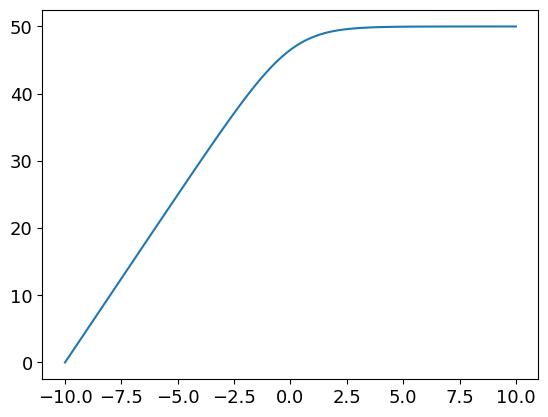

In [72]:
import multidms.model
x = jnp.array(onp.linspace(-10, 10, 100))
custom_params = {"ge_scale":jnp.array([5]) , "ge_bias":jnp.array([50])}
y = multidms.model.softplus_global_epistasis(custom_params, x)
plt.plot(x, y)
plt.show()

In [73]:
datasets

,scale_counts,min_pre_counts,pseudocount,sample,clip_target,trim,reference_condition,conditions,data
0,False,100,0.1,False,"(-3.5, 2.5)",False,Delta-2,"[Delta-2, Delta-3, Omicron_BA.1-2, Omicron_BA....",<multidms.data.MultiDmsData object at 0x7f94d2...
1,False,100,0.1,False,"(-3.5, 2.5)",False,Omicron_BA.1-2,"[Omicron_BA.1-2, Omicron_BA.2-1]",<multidms.data.MultiDmsData object at 0x7f94cc...
2,False,100,0.1,False,"(-3.5, 2.5)",False,Omicron_BA.1-3,"[Omicron_BA.1-3, Omicron_BA.2-2]",<multidms.data.MultiDmsData object at 0x7f94ae...


In [74]:
datasets.loc[0, "data"].site_map.loc[[95, 142], :]

,Delta-2,Delta-3,Omicron_BA.1-2,Omicron_BA.1-3,Omicron_BA.2-1,Omicron_BA.2-2
95,T,T,I,I,T,T
142,D,D,D,D,D,D


## `MultiDmsModel`

**To fit a mopdel, we first choose a dataset(s) we would like to fit**

In [29]:
# un-comment to re-initialize results
models = defaultdict(list)

**Next, we iterate through datasets and model definitions of interest and (1) initialize a model object with the respective dataset (2) fit that data to a model with some given hyperparameters and (3) save the models in a dataframe for comparison and plotting.**

In [75]:
import multidms.model as model
for dataset in [1,2]:
    for ge_func in [model.perceptron_global_epistasis, model.sigmoidal_global_epistasis]:
        for output_act in [model.softplus_activation]:
            
            imodel = multidms.MultiDmsModel(
                    datasets.loc[dataset, 'data'],
                    epistatic_model=ge_func,
                    output_activation=output_act,
                    n_percep_units=10
            )
            
            start = time.time()
            imodel.fit(lasso_shift=1e-5, maxiter=5000, tol=1e-6)
            end = time.time()
            print(f"done. fitting time = {round(end - start)} seconds")
            
            models["model"].append(imodel)
            models["dataset"].append(dataset)
            
models_df = pd.DataFrame(models)
models_df.tail(20)

done. fitting time = 88 seconds
done. fitting time = 83 seconds
done. fitting time = 82 seconds
done. fitting time = 77 seconds


,model,dataset
0,<multidms.model.MultiDmsModel object at 0x7f94...,0
1,<multidms.model.MultiDmsModel object at 0x7f94...,1
2,<multidms.model.MultiDmsModel object at 0x7f94...,1
3,<multidms.model.MultiDmsModel object at 0x7f94...,2
4,<multidms.model.MultiDmsModel object at 0x7f94...,2


In [32]:
import matplotlib.colors as colors
# palette = [
#     '#BFBFBF', '#404040',
#     '#A6CEE3', '#1F78B4', '#FB9A99', '#E31A1C'
# ]
palette = [
    '#BFBFBF','#404040',
    '#F97306', '#FFA500',
    '#9400D3', '#EE82EE',
]

for row, values in datasets.iterrows():
    conditions = sorted(values["data"].conditions)
    cc = {con:tuple(colors.to_rgb(col)) for con, col in zip(conditions, palette)}
    values.data.condition_colors = cc

In [104]:
# for m in [0, 1]:
#     model = models_df.loc[m, "model"]
#     chart = model.mut_shift_plot()
#     chart.save(f"altair-chart-{m}.html")

/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():
/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


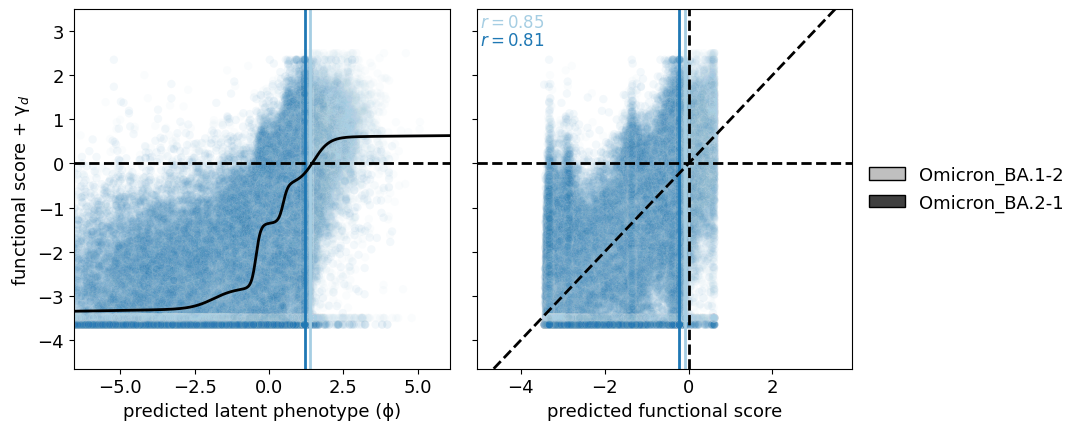

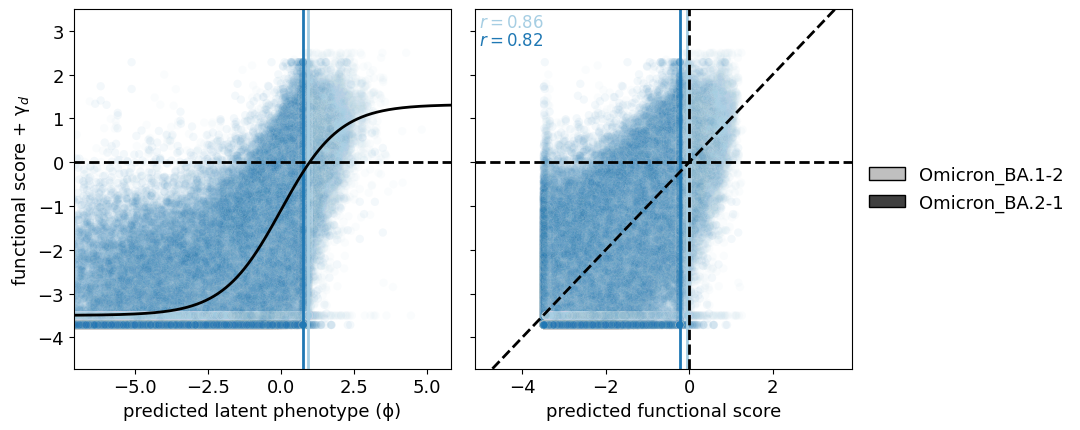

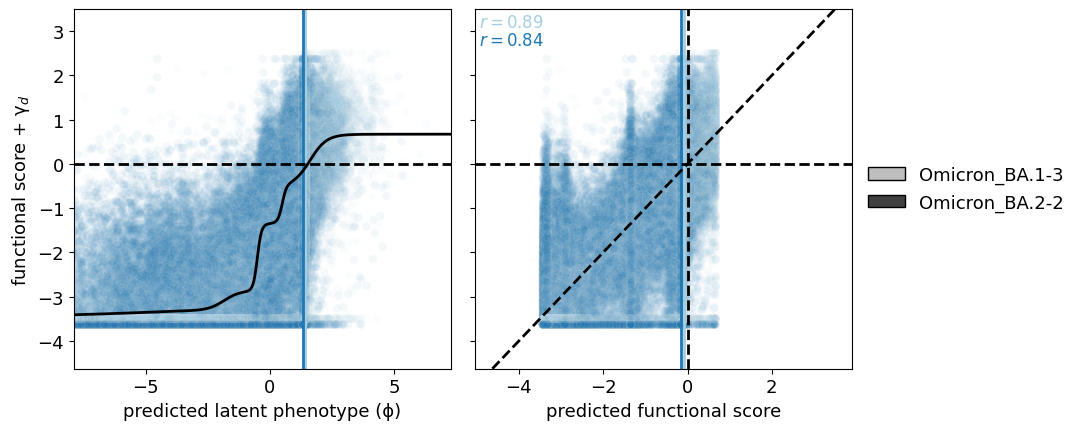

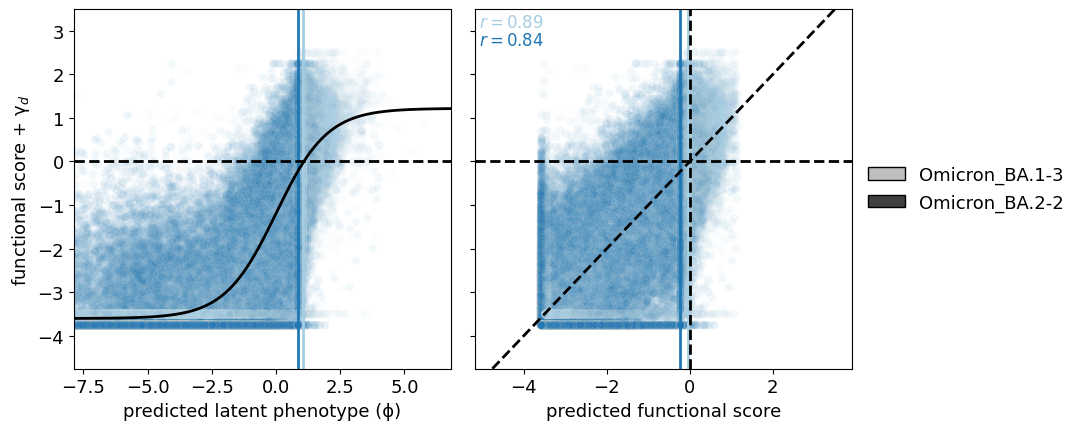

In [77]:
import matplotlib.colors as colors
plt.rcParams.update({'font.size': 13})

for m in [1,2,3,4]:
    model = models_df.loc[m, "model"]
    conditions = sorted(model.data.conditions)
    cc = {con:tuple(colors.to_rgb(col)) for con, col in zip(conditions, palette)}


    fig, ax = plt.subplots(1, 2, figsize=[11,4.5], sharey=True)
    
    
    model.plot_epistasis(ax=ax[0], alpha=0.05, show=False, legend=False)
    model.plot_pred_accuracy(ax=ax[1], alpha=0.05, show=False, legend=False)
    legend_elements = [
        patches.Patch(
             facecolor=col, 
             edgecolor="black", 
             label=con
        )
        for con, col in cc.items()
    ]
    ax[1].legend(
            handles=legend_elements, 
            loc='center left', bbox_to_anchor=(1, 0.5),
            frameon=False
    )
    plt.tight_layout()
    plt.show()

    fig.savefig(f"{model.data.reference}-ref-scatter-{m}.png")

In [78]:
models_df.loc[0, "model"].mut_shift_plot()

/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [ ]:
models_df.loc[1, "model"].mut_shift_plot()

In [189]:
plt.rcParams.update({'font.size': 13})

from functools import reduce
mutations_dfs = []
for model, ge_func in zip([17, 18], ["Delta-2-ref", "Delta-3-ref"]):
    mut_df = models_df.loc[model, "model"].mutations_df.set_index("mutation")
    
    new_column_name_map = {c:f"{c}_{ge_func}" for c in mut_df.columns}
    mut_df = mut_df.rename(new_column_name_map, axis=1)
    times_seen_cols = [c for c in mut_df.columns if "times" in c]
    for c in times_seen_cols:
        mut_df = mut_df[mut_df[c] >= 3]
    mutations_dfs.append(mut_df)
    

df_merged = reduce(
    lambda  left,right: pd.merge(
        left,
        right,
        left_index=True, 
        right_index=True,
        how='inner'
    ), 
    mutations_dfs
)
df_merged.head()

df_merged = df_merged.assign(is_stop = [True if "*" in mut else False for mut in df_merged.index])

In [190]:
df_merged.head()

,wts_Delta-2-ref,sites_Delta-2-ref,muts_Delta-2-ref,times_seen_Delta-3_Delta-2-ref,times_seen_Delta-4_Delta-2-ref,times_seen_Omicron_BA.1-2_Delta-2-ref,times_seen_Omicron_BA.1-3_Delta-2-ref,times_seen_Omicron_BA.2-1_Delta-2-ref,times_seen_Omicron_BA.2-2_Delta-2-ref,β_Delta-2-ref,...,F_Delta-2_Delta-3-ref,S_Omicron_BA.1-2_Delta-3-ref,F_Omicron_BA.1-2_Delta-3-ref,S_Omicron_BA.1-3_Delta-3-ref,F_Omicron_BA.1-3_Delta-3-ref,S_Omicron_BA.2-1_Delta-3-ref,F_Omicron_BA.2-1_Delta-3-ref,S_Omicron_BA.2-2_Delta-3-ref,F_Omicron_BA.2-2_Delta-3-ref,is_stop
mutation,,,,,,,,,,,,,,,,,,,,,
M1I,M,1,I,8.0,11.0,5.0,6.0,6.0,10.0,-5.536673,...,-3.499971,0.050346,-4.281126,-0.101040,-4.357316,0.028815,-4.296610,-0.508723,-4.572012,False
F2L,F,2,L,7.0,10.0,12.0,6.0,19.0,15.0,0.265901,...,-0.020972,-0.055897,-0.027777,-0.014777,-0.022736,-0.540276,-0.104476,0.004447,-0.020446,False
V3A,V,3,A,3.0,6.0,21.0,24.0,8.0,15.0,-0.382717,...,-0.112883,0.109118,-0.091658,-0.027212,-0.118516,0.002367,-0.112400,-0.058649,-0.125201,False
V3F,V,3,F,12.0,18.0,68.0,74.0,79.0,65.0,-0.381620,...,-0.153429,-0.139701,-0.189338,-0.038388,-0.162853,-0.106254,-0.180328,0.052930,-0.140958,False
V3G,V,3,G,8.0,7.0,50.0,31.0,38.0,27.0,-0.079599,...,-0.106072,0.066770,-0.093238,0.180696,-0.073091,0.073320,-0.092021,0.045571,-0.097228,False


/tmp/ipykernel_26683/3797234061.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_agg = data.groupby("sites_Delta-2-ref").sum()


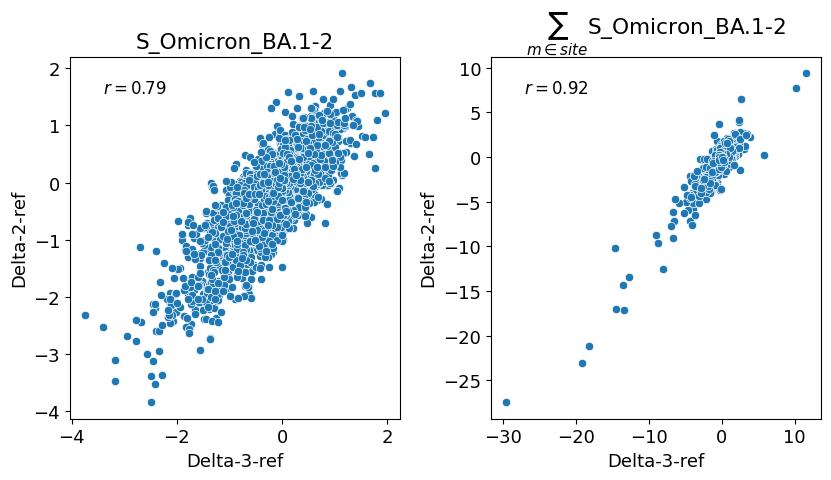

In [217]:
fig, ax = plt.subplots(1,2,figsize=[8.5, 5])
from scipy.stats import pearsonr

shifts_map = {
    c:c.split("_")[-1] 
    for c in df_merged.columns 
    if "S_Omicron_BA.1-2" in c
}
data = df_merged.rename(shifts_map, axis=1)
g = sns.scatterplot(
    data = data, 
    x="Delta-3-ref",
    y="Delta-2-ref",
    ax=ax[0]
)

r = pearsonr(
    data["Delta-3-ref"], data["Delta-2-ref"]
)[0]

ax[0].annotate(
    f"$r = {r:.2f}$",
    (0.1, 0.9),
    xycoords="axes fraction",
    fontsize=12
)
ax[0].set_title("S_Omicron_BA.1-2")

data_agg = data.groupby("sites_Delta-2-ref").sum()
g = sns.scatterplot(
    data = data_agg, 
    x="Delta-3-ref",
    y="Delta-2-ref",
    ax=ax[1]
)

r = pearsonr(
    data_agg["Delta-3-ref"], data_agg["Delta-2-ref"]
)[0]

ax[1].annotate(
    f"$r = {r:.2f}$",
    (0.1, 0.9),
    xycoords="axes fraction",
    fontsize=12
)
ax[1].set_title("$\sum_{m \in site}$S_Omicron_BA.1-2")


# g.savefig("shift-correlation.png")
plt.tight_layout()
fig.savefig("Delta-ref-omi-corr.png")
plt.show()

In [219]:
# fig, ax = plt.subplots(1,2,figsize=[8, 4])
from scipy.stats import pearsonr

mut_df = models_df.loc[17, "model"].mutations_df
times_seen_cols = [c for c in mut_df.columns if "times" in c]
for c in times_seen_cols:
    mut_df = mut_df[mut_df[c] >= 3]
mut_df

,mutation,wts,sites,muts,times_seen_Delta-3,times_seen_Delta-4,times_seen_Omicron_BA.1-2,times_seen_Omicron_BA.1-3,times_seen_Omicron_BA.2-1,times_seen_Omicron_BA.2-2,...,S_Delta-4,F_Delta-4,S_Omicron_BA.1-2,F_Omicron_BA.1-2,S_Omicron_BA.1-3,F_Omicron_BA.1-3,S_Omicron_BA.2-1,F_Omicron_BA.2-1,S_Omicron_BA.2-2,F_Omicron_BA.2-2
1,M1I,M,1,I,8.0,11.0,5.0,6.0,6.0,10.0,...,-1.036560,-2.922177,-0.019826,-2.709290,0.066929,-2.543255,0.019558,-2.897563,-0.249582,-2.888460
10,F2L,F,2,L,7.0,10.0,12.0,6.0,19.0,15.0,...,0.001272,0.332242,0.051848,0.390257,0.112914,0.459078,-0.338210,-0.076462,0.062773,0.402670
15,V3A,V,3,A,3.0,6.0,21.0,24.0,8.0,15.0,...,0.216107,-0.194226,0.388999,0.020605,0.389537,0.021265,0.143386,-0.285703,0.140411,-0.289454
19,V3F,V,3,F,12.0,18.0,68.0,74.0,79.0,65.0,...,-0.066551,-0.549323,-0.050599,-0.529224,0.002634,-0.462055,-0.044883,-0.522019,0.040264,-0.414520
20,V3G,V,3,G,8.0,7.0,50.0,31.0,38.0,27.0,...,0.291109,0.267398,0.050343,-0.023145,0.204845,0.165021,0.120682,0.063197,0.090652,0.026460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10737,S1252T,S,1252,T,32.0,24.0,114.0,94.0,94.0,88.0,...,-0.043371,-0.453914,0.132821,-0.231580,0.029352,-0.362041,0.001819,-0.396824,-0.003630,-0.403708
10738,S1252V,S,1252,V,16.0,14.0,80.0,61.0,68.0,65.0,...,0.115342,-0.017146,0.534084,0.476359,0.697875,0.652668,0.278487,0.181190,0.202669,0.089798
10739,S1252W,S,1252,W,5.0,7.0,24.0,29.0,28.0,30.0,...,0.284227,0.835575,-0.165403,0.359986,0.081342,0.631605,-0.296679,0.206510,-0.020409,0.522516
10740,S1252Y,S,1252,Y,29.0,33.0,95.0,88.0,126.0,157.0,...,-0.045256,0.512268,0.146976,0.715394,0.505435,1.049089,0.054058,0.619181,0.054385,0.619527


/tmp/ipykernel_26683/429486518.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_agg = data.groupby("sites").sum()


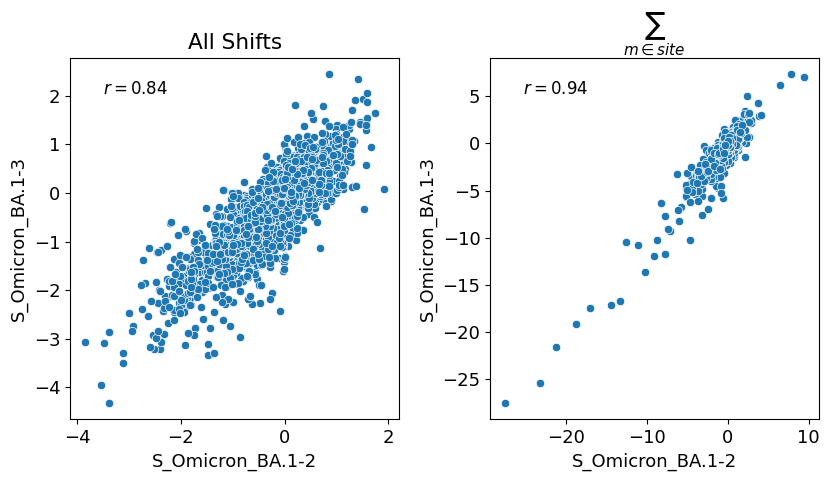

In [220]:
fig, ax = plt.subplots(1,2,figsize=[8.5, 5])

data = mut_df

g = sns.scatterplot(
    data = data, 
    x="S_Omicron_BA.1-2",
    y="S_Omicron_BA.1-3",
    ax=ax[0]
)

r = pearsonr(
    data["S_Omicron_BA.1-2"], data["S_Omicron_BA.1-3"]
)[0]

ax[0].annotate(
    f"$r = {r:.2f}$",
    (0.1, 0.9),
    xycoords="axes fraction",
    fontsize=12
)
ax[0].set_title("All Shifts")

data_agg = data.groupby("sites").sum()
g = sns.scatterplot(
    data = data_agg, 
    x="S_Omicron_BA.1-2",
    y="S_Omicron_BA.1-3",
    ax=ax[1]
)

r = pearsonr(
    data_agg["S_Omicron_BA.1-2"], data_agg["S_Omicron_BA.1-3"]
)[0]

ax[1].annotate(
    f"$r = {r:.2f}$",
    (0.1, 0.9),
    xycoords="axes fraction",
    fontsize=12
)
ax[1].set_title("$\sum_{m \in site}$")


# g.savefig("shift-correlation.png")
plt.tight_layout()
fig.savefig("single-fit-omi-corr.png")
plt.show()

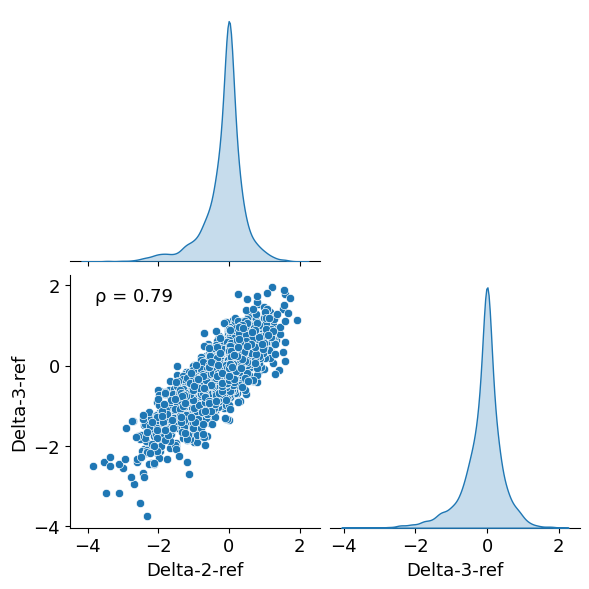

In [191]:
# fig, ax = plt.subplots(figsize=[9, 9])
from scipy.stats import pearsonr
shifts_map = {
    c:c.split("_")[-1] 
    for c in df_merged.columns 
    if "S_Omicron_BA.1-2" in c
}
g = sns.pairplot(
    data = df_merged.rename(shifts_map, axis=1), 
    vars=shifts_map.values(), 
#     hue="is_stop", 
    diag_kind="kde", 
    corner=True,
    height=3
#     ax=ax
)
def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    
g.map_lower(corrfunc)

g.savefig("shift-correlation.png")
plt.show()

In [56]:
model.params['α']

{'p_biases': DeviceArray([-0.83786461,  1.55572419,  0.14314948, -1.38693121,
               0.93936036], dtype=float64),
 'p_weights_1': DeviceArray([1.06963075, 0.        , 0.24082365, 0.        , 0.27765072],            dtype=float64),
 'p_weights_2': DeviceArray([0.        , 0.72272396, 0.        , 1.63609773, 0.        ],            dtype=float64)}

### Visualization

In [54]:
chart = a_model_object.mut_shift_plot()

/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


In [55]:
# chart.save("scaled-delta-3.html")

**The one mutable attribute of MultiDmsData objects is the condition_colors. We will set a custom color patte to be shared across datasets such that our multiple fit plots are consistant.**

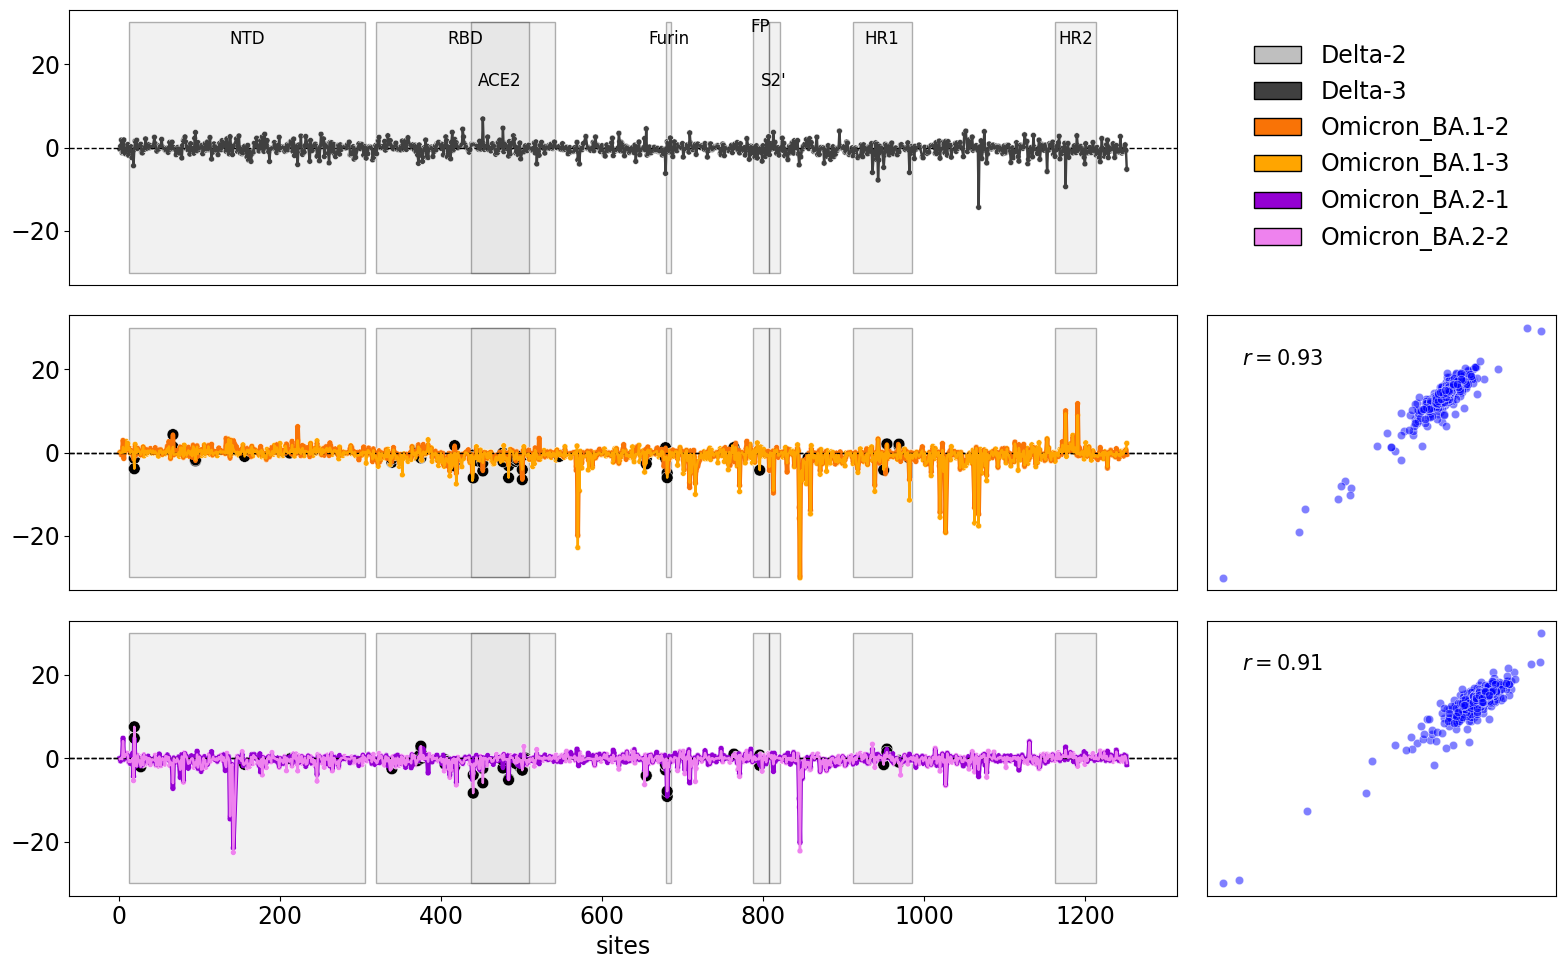

In [103]:
def sum_abs(x): 
    return sum([abs(t) for t in x if t == t])
def mean_abs(x): 
    return onp.mean([abs(t) for t in x if t == t])
def max_abs(x): 
    return onp.max([abs(t) for t in x if t == t])

plt.rcParams.update({'font.size': 17})

#         aceX
for model in [1]:
    fig = plt.figure(constrained_layout=True, figsize=(16,10))
    axd = fig.subplot_mosaic(
        """
        bbbg
        dddh
        fffi
        """,
        empty_sentinel="X",
        gridspec_kw={ 
        }
    )

    protein_regions = {
        "NTD" :  [13, 305],                                                 
        "RBD" : [319, 541],
        "ACE2" : [437, 508],
        "Furin" : [680, 685],
        "FP" : [788, 806],
        "S2'"  : [808, 820],
        "HR1" : [912, 984],
        "HR2" : [1163, 1213]
    }
    
    

    moi = models_df.loc[model, "model"]
#     fig.suptitle(f"reference: {moi.data.reference}")
#     fig.suptitle(f"Reference: {moi.data.reference}\n")
#     moi.plot_epistasis(show=False, legend=False, alpha=0.05, ax=axd["c"])
#     moi.plot_pred_accuracy(show=False, legend=False, alpha=0.05, ax=axd["e"], annotate_corr=False)

    facet_groups = {
        ("b", "g") : ("Delta-2", "Delta-3"),
        ("d", "h") : ("Omicron_BA.1-2", "Omicron_BA.1-3"),
        ("f", "i") : ("Omicron_BA.2-1", "Omicron_BA.2-2")
    }

    for axi, facet_group in facet_groups.items():

        for pr, data in protein_regions.items():

            start = data[0]
            end = data[1] + 1
            width = end - start
            middle = start + (width//2)

            rect_v = patches.Rectangle(
                    (start, -30),
                    width=width,
                    height=60,
                    clip_on=False,
                    linewidth=1,
                    edgecolor='black',
                    facecolor='lightgrey',
                    alpha=0.3
            )
            axd[axi[0]].add_patch(rect_v)

#         condition_ylabel = []
        for r, condition in enumerate(facet_group):
            
            if condition == moi.data.reference: continue
            lw=3.25 if r == 0 else 1.75
#                 color = moi.data.condition_colors[condition]
#             else:
#                 lw=1
#                 color = 'black'
            
#             condition_ylabel.append(condition)
            moi.plot_shifts_by_site(
                condition,
                show=False, 
                agg_func=onp.sum,
                times_seen_threshold=3,
                ax=axd[axi[0]],
                lw=lw
#                 lw=lw, color=color
#                 alpha=0.8
            )
            
#         ylabel =  '\n' + '\n'.join(condition_ylabel)
#         if axi[0] == "d":
#             ylabel = "$\sum_{m \in site}s_{m,d}$\n" + ylabel
#         axd[axi[0]].set_ylabel(ylabel)
        axd[axi[0]].set_ylabel("")

#         axd[axi[0]].get_xaxis().set_visible(False)
#         axd[axi[0]].get_yaxis().set_visible(False)
        
        if moi.data.reference not in facet_group:
            
            from scipy.stats import pearsonr
            
            mut_df = moi.mutation_site_summary_df(agg_func=onp.sum, times_seen_threshold=3)
#             mut_df = moi.mutations_df
            
#             times_seen_cols = [c for c in mut_df.columns if "times" in c]
#             for c in times_seen_cols:
#                 mut_df = mut_df[mut_df[c]>=3]
                
            x = mut_df[f"S_{facet_group[0]}"].values
            y = mut_df[f"S_{facet_group[1]}"].values
            r = pearsonr(x, y)[0]
            sns.scatterplot(mut_df,
                x=f"S_{facet_group[0]}",
                y=f"S_{facet_group[1]}", 
                ax=axd[axi[1]],
                alpha=0.5,
                color="blue"
                
            )
            axd[axi[1]].annotate(
                f"$r = {r:.2f}$", (0.1, 0.82),
                xycoords="axes fraction", fontsize=15, color="black"
            )
            
#             legend_elements = [
# #                 patches.Patch(
# #                      facecolor="black", 
# #                      edgecolor="black", 
# #                      label="all muts"
# #                 ),
#                 patches.Patch(
#                     facecolor="blue", 
#                     edgecolor="black", 
#                     label="$\sum$" #_{m \in site}s_{m,d}$"
#                 )
                
#             ]
#             axd[axi[1]].legend(
#                     handles=legend_elements, 
#                     loc="lower right",
#                     frameon=False,
#                     fontsize=12
#             )
            
#             mut_df = moi.mutations_df
            
#             times_seen_cols = [c for c in mut_df.columns if "times" in c]
#             for c in times_seen_cols:
#                 mut_df = mut_df[mut_df[c]>=3]
                
#             x = mut_df[f"S_{facet_group[0]}"].values
#             y = mut_df[f"S_{facet_group[1]}"].values
#             r = pearsonr(x, y)[0]
#             sns.scatterplot(mut_df,
#                 x=f"S_{facet_group[0]}",
#                 y=f"S_{facet_group[1]}", 
#                 ax=axd[axi[1]],
#                 alpha=0.5,
#                 color="black"
#             )
#             axd[axi[1]].annotate(
#                 f"$r = {r:.2f}$", (0.1, 0.9),
#                 xycoords="axes fraction", fontsize=12, color="black"
#             )
            axd[axi[1]].get_xaxis().set_visible(False)
            axd[axi[1]].get_yaxis().set_visible(False)
            
        
                 
        else:
            
            axd[axi[1]].axis('off')
            
            conditions = sorted(moi.data.conditions)
            cc = {con:tuple(colors.to_rgb(col)) for con, col in zip(conditions, palette)}
            legend_elements = [
                patches.Patch(
                     facecolor=col, 
                     edgecolor="black", 
                     label=con
                )
                for con, col in cc.items()
            ]
            axd[axi[1]].legend(
                    handles=legend_elements, 
                    loc="center",
                    frameon=False
            )
            
    for pr, data in protein_regions.items():

        start = data[0]
        end = data[1] + 1
        width = end - start
        middle = start + (width//2)

        anno = f"{pr}" #": \n{start}-{end}"
        ycoord = 26
        if pr in ["ACE2", "S2'"]:
            ycoord = 16
        if pr in ["FP"]:
            ycoord = 29

        axd["b"].text(middle, ycoord, anno, va="center", ha="center", size=12, rotation=0)

    axd["b"].get_xaxis().set_visible(False)
    axd["d"].get_xaxis().set_visible(False)
    

#     fig.text(0.00, 0.5, "$\sum_{m \in site}s_{m,d}$", va='center', rotation='vertical')
    plt.tight_layout()
    plt.show()

    fig.savefig(f"shifts_reference_{moi.data.reference}.png")

In [94]:
# import pickle
# moi = models_df.loc[0, "model"]
# pickle.dump(moi, open("delta-6c-sigmoid.pkl", "wb"))

In [ ]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(constrained_layout=True, figsize=(14,8))
axd = fig.subplot_mosaic(
    """
    abcg
    defX
    """,
    empty_sentinel="X",
#     sharex=True,
#     sharey=True,
    width_ratios=[2, 2, 2, 1],
)

# which fits go where
model_ax_dict = {
    "a" : 0,
    "b" : 1,
    "c" : 2,
    "d" : 0,
    "e" : 1,
    "f" : 2
}

for axi, model in model_ax_dict.items():
    moi = models_df.loc[model, "model"]
    if axi in ["a", "b", "c"]:
        moi.plot_epistasis(show=False, legend=False, alpha=0.15, ax=axd[axi])
    else:
        moi.plot_pred_accuracy(show=False, legend=False, alpha=0.15, ax=axd[axi])
    
    epi = "Sigmoid"
    if axi in ["b", "e"]:
        epi = "Softplus"
    if axi in ["c", "f"]:
        epi = "Identity"
        
    axd[axi].set_title(epi)

axd["b"].set_ylabel("")
axd["e"].set_ylabel("")
axd["c"].set_ylabel("")
axd["f"].set_ylabel("")

axd["a"].set_xlabel("")
axd["d"].set_xlabel("")
axd["c"].set_xlabel("")
axd["f"].set_xlabel("")

axd["g"].axis('off')
legend_elements = [
    patches.Patch(
         facecolor=col, 
         edgecolor="black", 
         label=con
    )
    for con, col in cc.items()
]
axd["g"].legend(
        handles=legend_elements, 
        loc="center",
        frameon=False
)
plt.tight_layout()
fig.savefig("epi-model-compare.png")
plt.show()